In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import ast

In [427]:
import numpy as np
import matplotlib.pyplot as plt
import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable

### 1. Preprocessing

In [3]:
#learning info
model_info = "4c_2f_512_yield"
maxlen = 20
fp_len = 512
path = './data/'

toxic_name_ = "ammonia"
fail_name = "N"

#read ammonia data
reaction_list = []
f = open(path + 'toxic_fp' + str(fp_len) + toxic_name_, 'r', encoding='UTF8')

while True:
    line = f.readline()
    if not line: break
    reaction = ast.literal_eval(line)
    reaction_list.append(reaction)
f.close()

ammonia_list = []
for reaction in reaction_list:
    in_des = []
    for reactants in reaction[0]:
        in_des = in_des + reactants
    while len(in_des) < fp_len*maxlen:
        in_des.append(0)
    ammonia_list.append([torch.FloatTensor(in_des), reaction[1]])

#read failed data
reaction_list = []
f = open(path + 'failed_fp' + str(fp_len) + '_with_yield_' + fail_name, 'r', encoding='UTF8')

while True:
    line = f.readline()
    if not line: break
    reaction =ast.literal_eval(line)
    reaction_list.append(reaction)
f.close()

failed_list = []
for reaction in reaction_list:
    in_des = []
    for reactants in reaction[0]:
        in_des = in_des + reactants
    while len(in_des) < fp_len*maxlen:
        in_des.append(0)
    failed_list.append([torch.FloatTensor(in_des), reaction[1]])


#read cv data
f = open('./cv_index_list', 'r', encoding='UTF8')
cvdata = ast.literal_eval(f.readline())
f.close()
failed_cv = cvdata[0]
ammonia_cv = cvdata[1]

#data divide with 10 cv - 10% test, other tv. tv randomly shuffle and 10% - val for early stop, 80% for train
test_10cv = []
test_failed_tmp = []
for test_index in failed_cv[9]:
    test_failed_tmp.append(failed_list[test_index])
test_10cv.append(test_failed_tmp)
test_ammonia_tmp = []
for test_index in ammonia_cv[9]:
    test_ammonia_tmp.append(ammonia_list[test_index])
test_10cv.append(test_ammonia_tmp)

### 2. Model Definition

In [354]:
#model
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, fp_len, kernel_size=(fp_len,1), stride=fp_len)
        self.conv2 = nn.Conv2d(1, int(fp_len/2), kernel_size=(fp_len,1), stride=fp_len)
        self.conv3 = nn.Conv2d(1, int(fp_len/2), kernel_size=(int(fp_len/2),1), stride=int(fp_len/2))
        self.conv4 = nn.Conv2d(1, int(fp_len/2), kernel_size=(int(fp_len/2),1), stride=int(fp_len/2))
        self.fc1 = nn.Linear(int(fp_len/2), int(fp_len/4))
        self.fc2 = nn.Linear(int(fp_len/4), 1)

    def forward(self, input_tensor):
        input_reshaped = inpute_tensor.view(1, 1, int(fp_len*maxlen), 1)
        conv1_output = F.relu(self.conv1(input_reshaped))
        conv1_reshaped = conv1_output.view(1, 1, int(fp_len*maxlen), 1)
        conv2_output = self.conv2(conv1_reshaped)
        conv2_reshaped = conv2_output.view(1, 1, int(fp_len*maxlen/2), 1)
        conv3_output = self.conv3(conv2_reshaped)
        conv3_reshaped = conv3_output.view(1, 1, int(fp_len*maxlen/2), 1)
        conv4_output = self.conv4(conv3_reshaped)
        conv4_reshaped = conv4_output.view(1, 1, int(fp_len/2), maxlen)
        pool2d = F.max_pool2d(conv4_reshaped, kernel_size=(1, maxlen))
        pool2d_reshaped = pool2d.view(int(fp_len/2))
        fc1_output = F.relu(self.fc1(pool2d_reshaped))
        fc2_output = torch.sigmoid(self.fc2(fc1_output))

        activations = [input_tensor, conv1_output, conv2_output, conv3_output, conv4_output, pool2d, fc1_output, fc2_output]
        max_pool2d = [(1, maxlen), None, 0]
        reshaped = [input_reshaped, conv1_reshaped, conv2_reshaped, conv3_reshaped, conv4_reshaped, pool2d_reshaped, \
                    fc1_output, fc2_output]
        
        output = {'activations': activations, 'max_pool2d': max_pool2d, 'reshaped': reshaped}
        return output

print(Net())

Net(
  (conv1): Conv2d(1, 512, kernel_size=(512, 1), stride=(512, 512))
  (conv2): Conv2d(1, 256, kernel_size=(512, 1), stride=(512, 512))
  (conv3): Conv2d(1, 256, kernel_size=(256, 1), stride=(256, 256))
  (conv4): Conv2d(1, 256, kernel_size=(256, 1), stride=(256, 256))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


### 3. Test the Model

**3-1. Restore Model**

In [355]:
PATH = './' + model_info + str(0) + '.pth'
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [357]:
from torchsummary import summary
summary(net, input_size=(1, 10, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 512, 20, 1]         262,656
            Conv2d-2           [-1, 256, 20, 1]         131,328
            Conv2d-3           [-1, 256, 20, 1]          65,792
            Conv2d-4           [-1, 256, 20, 1]          65,792
            Linear-5                       [-1]          32,896
            Linear-6                       [-1]             129
Total params: 558,593
Trainable params: 558,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 2.13
Estimated Total Size (MB): 2.35
----------------------------------------------------------------


**3-2. Visualize the Heatmap**

**~~TODO: Implement backprop_maxpool, backprop_conv2d, ...~~**

In [383]:
class DTD(nn.Module):
    def __init__(self, lowest=0., highest=1.):
        super(DTD, self).__init__()
        self.lowest = lowest
        self.highest = highest
        self.Rs = []
        
    def forward(self, net, input_tensor):
        net_output = net(input_tensor)
        activations = net_output['activations']
        kernel_size, strides, padding = net_output['max_pool2d']
        reshaped = net_output['reshaped']
        
        modules = self.model_flattening(net)
        
        j = -1
        self.Rs.append(activations[j])
        j -= 1
        
        for i in range(len(modules)-1, -1, -1):
            if isinstance(modules[i], nn.Conv2d):
                if isinstance(modules[i+1], nn.Linear):
                    print('MaxPool')
                    R = self.backprop_max_pool(reshaped[j], kernel_size, strides, padding, self.Rs[-1])
                    R = R.view(activations[j].shape)
                    self.Rs.append(R)
                    j -= 1
                    print(self.Rs[-1].shape, '\n')
                    
                    print('Conv2d')
                    R = self.backprop_conv(reshaped[j], modules[i], self.Rs[-1])
                    R = R.view(activations[j].shape)
                    self.Rs.append(R)
                    j -= 1
                    print(self.Rs[-1].shape, '\n')
                    
                elif i == 0:
                    print('Conv2d Input')
                    R = self.backprop_conv_input(reshaped[j], modules[i], self.Rs[-1])
                    R = R.view(activations[j].shape)
                    self.Rs.append(R)
                    j -= 1
                    print(self.Rs[-1].shape, '\n')
                    
                else:
                    print('Conv2d')
                    R = self.backprop_conv(reshaped[j], modules[i], self.Rs[-1])
                    R = R.view(activations[j].shape)
                    self.Rs.append(R)
                    j -= 1
                    print(self.Rs[-1].shape, '\n')
                    
            elif isinstance(modules[i], nn.Linear):
                print('Linear')
                activation = reshaped[j].view(-1, modules[i].in_features)
                R = self.backprop_dense(activation, modules[i], self.Rs[-1])
                R = R.view(activations[j].shape)
                self.Rs.append(R)
                j -= 1
                print(self.Rs[-1].shape, '\n')
                
        return self.Rs

                
    def backprop_dense(self, activation, module, R):
        W = torch.clamp(module.weight, min=0)
        Z = torch.mm(activation, torch.transpose(W, 0, 1)) + 1e-9
        S = R / Z
        C = torch.mm(S, W)
        R = activation * C

        return R
    

    def backprop_conv(self, activation, module, R):
        stride, padding, kernel = module.stride, module.padding, module.kernel_size
        output_padding = activation.size(2) - ((R.size(2) - 1) * stride[0] \
                                        - 2 * padding[0] + kernel[0])
        W = torch.clamp(module.weight, min=0)
        Z = F.conv2d(activation, W, stride=stride, padding=padding) + 1e-9
        S = R / Z
        C = F.conv_transpose2d(S, W, stride=stride, padding=padding, output_padding=output_padding)
        R = activation * C

        return R

    
    def backprop_conv_input(self, activation, module, R):
        stride, padding, kernel = module.stride, module.padding, module.kernel_size
        output_padding = activation.size(2) - ((R.size(2) - 1) * stride[0] \
                                                - 2 * padding[0] + kernel[0])

        W_L = torch.clamp(module.weight, min=0)
        W_H = torch.clamp(module.weight, max=0)

        L = torch.ones_like(activation, dtype=activation.dtype) * self.lowest
        H = torch.ones_like(activation, dtype=activation.dtype) * self.highest

        Z_O = F.conv2d(activation, module.weight, stride=stride, padding=padding)
        Z_L = F.conv2d(L, W_L, stride=stride, padding=padding)
        Z_H = F.conv2d(H, W_H, stride=stride, padding=padding)

        Z = Z_O - Z_L - Z_H + 1e-9
        S = R / Z

        C_O = F.conv_transpose2d(S, module.weight, stride=stride, padding=padding, output_padding=output_padding)
        C_L = F.conv_transpose2d(S, W_L, stride=stride, padding=padding, output_padding=output_padding)
        C_H = F.conv_transpose2d(S, W_H, stride=stride, padding=padding, output_padding=output_padding)

        R = activation * C_O - L * C_L - H * C_H

        return R   

    
    def backprop_max_pool(self, activation, kernel_size, stride, padidng, R):
        #kernel_size, stride, padding = module.kernel_size, module.stride, module.padding
        Z, indices = F.max_pool2d(activation, kernel_size=kernel_size, stride=stride, \
                                  padding=padding, return_indices=True)
        Z = Z + 1e-9
        S = R / Z
        C = F.max_unpool2d(S, indices, kernel_size=kernel_size, stride=stride, \
                            padding=padding, output_size=activation.shape)
        R = activation * C

        return R
    
    
    def model_flattening(self, module_tree):
        module_list = []
        children_list = list(module_tree.children())
        if len(children_list) == 0:
            return [module_tree]
        else:
            for i in range(len(children_list)):
                module = model_flattening(children_list[i])
                module = [j for j in module]
                module_list.extend(module)
            return module_list

In [453]:
input_tensor = test_10cv[1][3][0]

dtd = DTD()
Rs = dtd(net, input_tensor)

print(Rs[-1].shape)
print(Rs[0].shape)

Linear
torch.Size([128]) 

Linear
torch.Size([1, 1, 256, 1]) 

MaxPool
torch.Size([1, 256, 20, 1]) 

Conv2d
torch.Size([1, 256, 20, 1]) 

Conv2d
torch.Size([1, 256, 20, 1]) 

Conv2d
torch.Size([1, 512, 20, 1]) 

Conv2d Input
torch.Size([1, 1, 10240, 1]) 

torch.Size([1, 1, 10240, 1])
torch.Size([1])


**Test if relevance score is conservative**

In [454]:
temp = Rs[-1].detach().numpy()
print('relevance_sum: ', np.sum(temp))

output = net(input_tensor)['activations'][-1]
print('output: ', output)

relevance_sum:  0.9979939
output:  tensor([0.9980], grad_fn=<SigmoidBackward>)


[ 0 : 512 ]


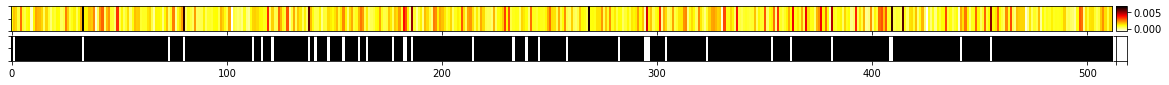

[ 512 : 1024 ]


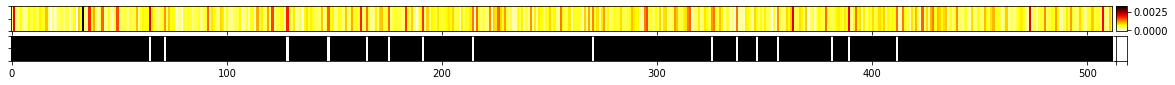

[ 1024 : 1536 ]


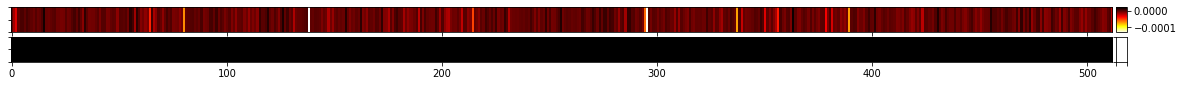

[ 1536 : 2048 ]


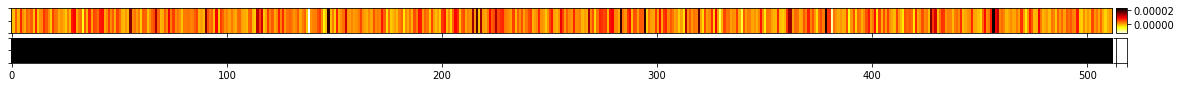

[ 2048 : 2560 ]


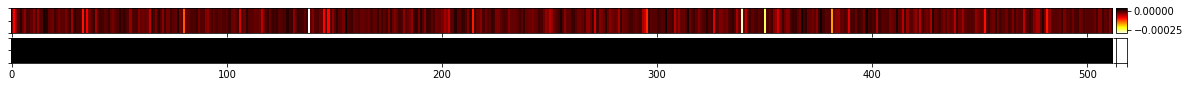

[ 2560 : 3072 ]


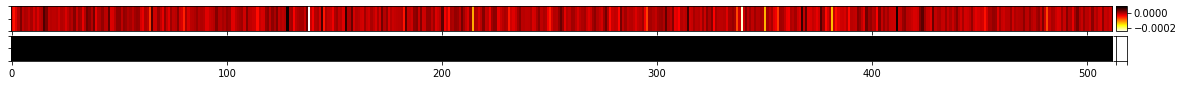

[ 3072 : 3584 ]


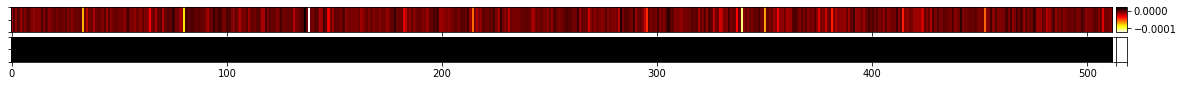

[ 3584 : 4096 ]


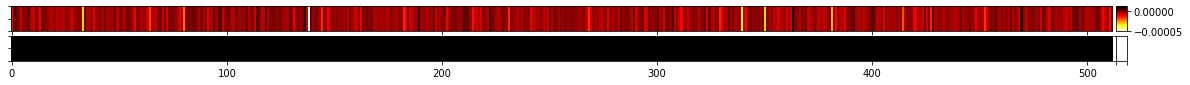

[ 4096 : 4608 ]


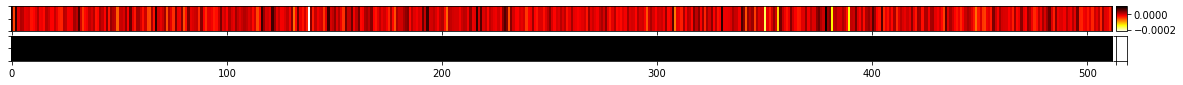

[ 4608 : 5120 ]


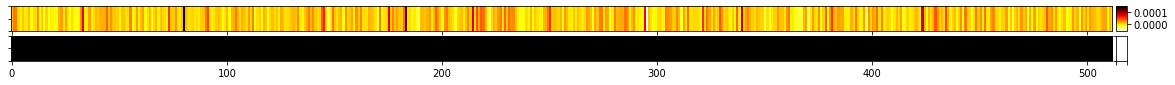

[ 5120 : 5632 ]


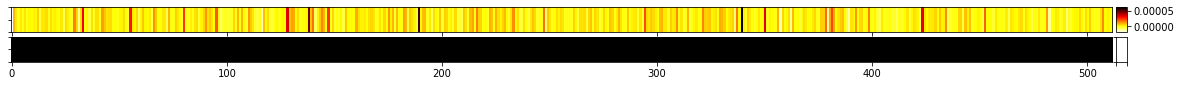

[ 5632 : 6144 ]


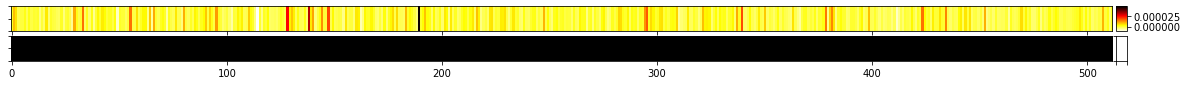

[ 6144 : 6656 ]


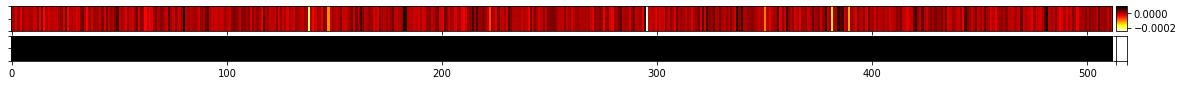

[ 6656 : 7168 ]


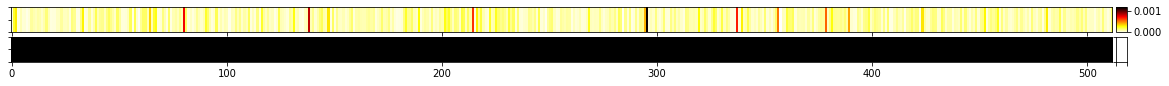

[ 7168 : 7680 ]


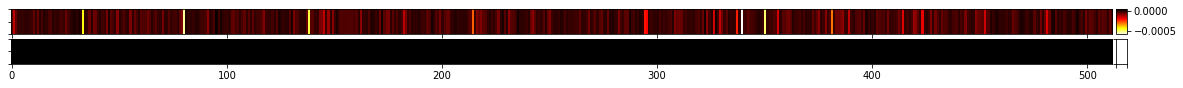

[ 7680 : 8192 ]


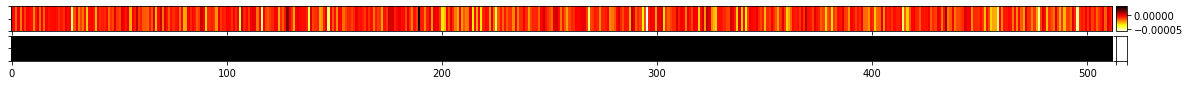

[ 8192 : 8704 ]


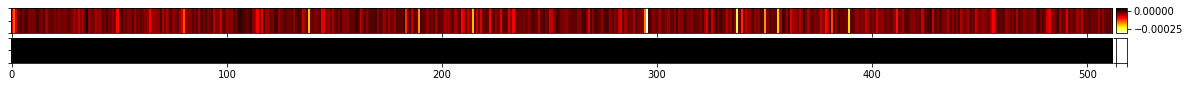

[ 8704 : 9216 ]


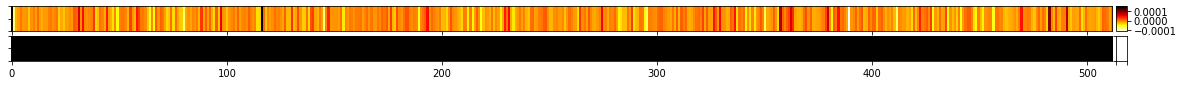

[ 9216 : 9728 ]


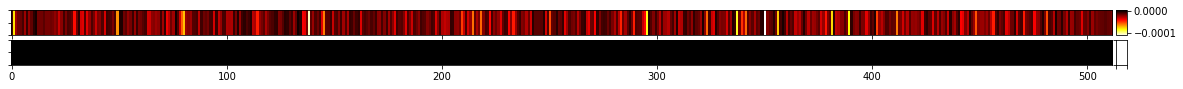

[ 9728 : 10240 ]


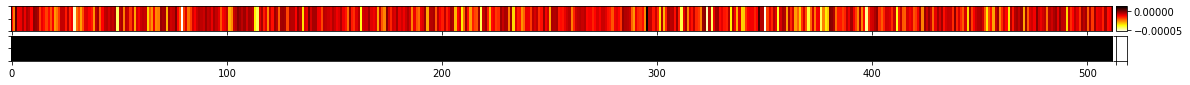

In [460]:
R = Rs[-1].detach().numpy()[0, 0, :, 0]

input_reshaped = input_tensor.view(1, 1, int(fp_len*maxlen), 1)
input_reshaped = input_reshaped.detach().numpy()[0, 0, :, 0]

for i in range(maxlen):
    print('[', 512*i, ':', 512*(i+1), ']')
    R_image = R[512*i:512*(i+1)]
    R_image = np.expand_dims(R_image, 0)
    
    fig = plt.figure(figsize=(20, 1))

    # Heatmap
    ax = plt.subplot(2, 1, 1)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(R_image, aspect='auto', cmap='hot_r')
    
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(cax=cax)
    cax.set_xticklabels([])
    
    # Input data
    ax = plt.subplot(2, 1, 2)
    
    ax.set_yticklabels([])
    input_image = input_tensor[512*i:512*(i+1)]
    input_image = np.expand_dims(input_image, 0)

    plt.imshow(input_image, aspect='auto', cmap='gray')

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    cax.set_xticklabels([])
    cax.set_yticklabels([])
    
    #plt.savefig(str(i)+'.png')
    #plt.clf()
    plt.show()